本文是初次参加Kaggle入门赛Titanic生还预测的一个过程记录，通过这个比赛，主要熟悉了pandas以及sklearn包的使用，对于常见的分类问题有了一定的了解。现将数据分析的过程记录如下。

In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier,RandomForestRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from mlxtend.classifier import StackingClassifier
%matplotlib inline


# 数据分析

In [2]:
train_df=pd.read_csv('data/train.csv')
test_df=pd.read_csv('data/test.csv')
data_all=pd.concat([train_df,test_df],ignore_index=True)
train_len=train_df.shape[0]
print(train_df.shape)
print(test_df.shape)

(891, 12)
(418, 11)


In [3]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


In [4]:
n = data_all.drop(['PassengerId','Survived'], axis=1).loc[:, data_all.isnull().any()].isnull().sum()
print('ALL:', data_all.shape[0])
print('-' * 30)
print(n.sort_values(ascending=False))

ALL: 1309
------------------------------
Cabin       1014
Age          263
Embarked       2
Fare           1
dtype: int64


## 填充缺失值

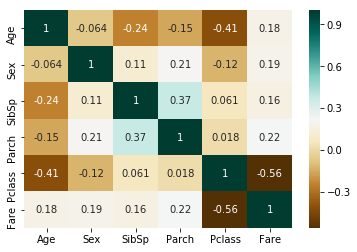

In [5]:
## Cabin缺失较多 考虑将其分为 有值和无值两类 或者直接弃用
# 这里直接弃用

## Fare只缺1个值，用均值或中值填充，这里采用中值填充
data_all['Fare'].fillna(data_all['Fare'].median(),inplace=True)

## Embarked缺失2个值，为object类型，这里考虑添加一组新值，以"None"填充
data_all['Embarked'].fillna('None',inplace=True)

## Age对于预测很重要，这里考虑用机器学习的方法对其进行预测填充，考虑到Age和SibSp,Parch以及Pclass，Fare等因素有关
# 分析Age的影响因素

# 性别可能对age有影响，先将sex转化为数值类型
# convert Sex into categorical value 0 for male and 1 for female
data_all["Sex"] = data_all["Sex"].map({"male": 0, "female":1})

g = sns.heatmap(data_all[["Age","Sex","SibSp","Parch","Pclass","Fare"]].corr(),cmap="BrBG",annot=True)
# 分析出Age与Sex关系较小，而与其它几个属性都有一定关系
# 考虑使用RF模型结合其它几个属性对Age进行预测填充

# 把已有的数值型特征取出来丢进Random Forest Regressor中
age_df = data_all[['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']]
# 乘客分成已知年龄和未知年龄两部分
known_age = age_df[age_df.Age.notnull()].as_matrix()
unknown_age = age_df[age_df.Age.isnull()].as_matrix()
# y即目标年龄
y = known_age[:, 0]
# X即特征属性值
X = known_age[:, 1:]

# fit到RandomForestRegressor之中
rfr = RandomForestRegressor(random_state=0, n_estimators=2000, n_jobs=-1)
rfr.fit(X, y)
# 用得到的模型进行未知年龄结果预测
predictedAges = rfr.predict(unknown_age[:, 1::])
# 用得到的预测结果填补原缺失数据
data_all.loc[(data_all.Age.isnull()), 'Age'] = predictedAges

In [6]:
# 显示数值类型的统计结果
print('number describe:\n',data_all.drop(['PassengerId','Survived'],axis=1).describe(include=['number']).loc[['min', 'max', 'mean','std','count']].T.sort_values('max'))

# 看出Age的缺失值已经被填充

number describe:
          min       max       mean        std   count
Sex     0.00    1.0000   0.355997   0.478997  1309.0
Pclass  1.00    3.0000   2.294882   0.837836  1309.0
SibSp   0.00    8.0000   0.498854   1.041658  1309.0
Parch   0.00    9.0000   0.385027   0.865560  1309.0
Age     0.17   80.0000  29.876751  13.447012  1309.0
Fare    0.00  512.3292  33.281086  51.741500  1309.0


In [7]:
# 显示object类型的取值
print('object describe:\n')
n = data_all.select_dtypes(include=object)
for c in n.columns:
    print('{:<14}'.format(c),':',len(data_all[c].unique()),'\n',data_all[c].unique())

object describe:

Cabin          : 187 
 [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B4

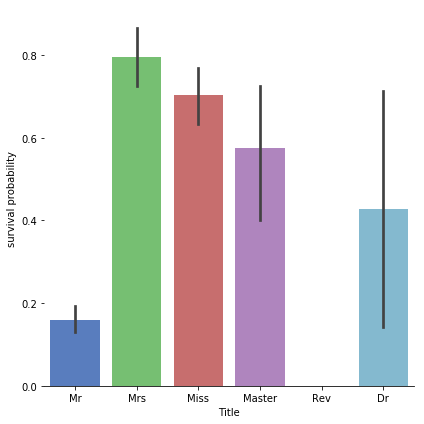

In [8]:
#对object特征分组
#处理Name属性
data_all['Title'] = data_all['Name']
# Cleaning name and extracting Title
for name_string in data_all['Name']:
    data_all['Title'] = data_all['Name'].str.extract('([A-Za-z]+)\.', expand=True)

# Replacing rare titles with more common ones
mapping = {'Mlle': 'Miss', 'Major': 'Mr', 'Col': 'Mr', 'Sir': 'Mr', 'Don': 'Mr', 'Mme': 'Miss',
               'Jonkheer': 'Mr', 'Lady': 'Mrs', 'Capt': 'Mr', 'Countess': 'Mrs', 'Ms': 'Miss', 'Dona': 'Mrs'}
data_all.replace({'Title': mapping}, inplace=True)

g = sns.factorplot(x="Title", y="Survived",  data=data_all.iloc[:train_len,:],
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")
# 分析得出女人小孩确实生存率更高

In [9]:
# 对Title进行编码
data_all['Title'].replace(['Mr','Miss','Mrs','Master','Rev','Dr'],[0,1,2,3,4,4],inplace=True)

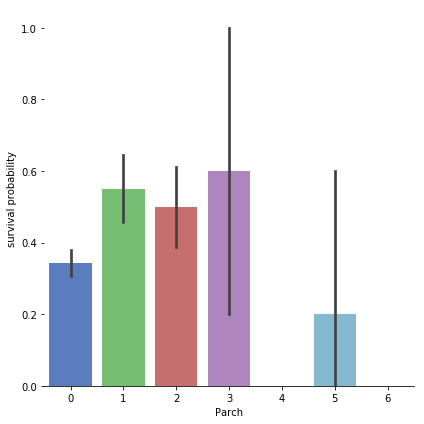

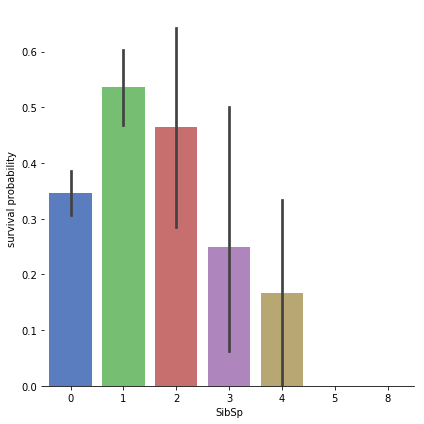

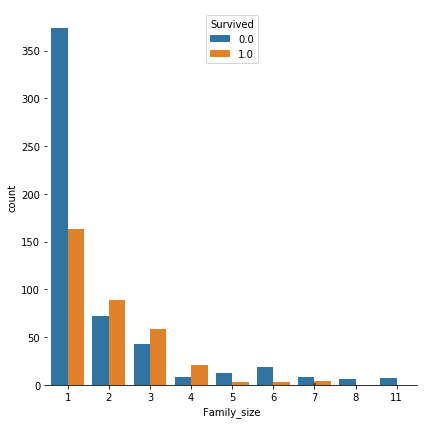

In [10]:
# 家族属性特征提取

# 合并Parch属性和SibSp属性，添加Family_size属性
data_all['Family_size']=data_all['Parch']+data_all['SibSp']+1

g = sns.factorplot(x="Parch", y="Survived",  data=data_all.iloc[:train_len,:],
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

g = sns.factorplot(x="SibSp", y="Survived",  data=data_all.iloc[:train_len,:],
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")


g = sns.factorplot(x="Family_size", y="Survived",  data=data_all.iloc[:train_len,:],
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

g = sns.countplot(x="Family_size", hue="Survived", data=data_all.iloc[:train_len,:]) 


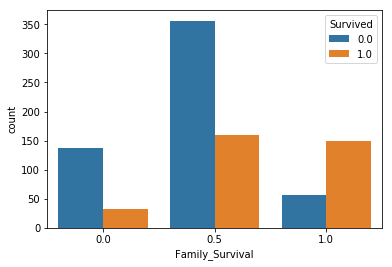

In [11]:
# 家族属性深挖
data_all['Last_Name'] = data_all['Name'].apply(lambda x: str.split(x, ",")[0])

DEFAULT_SURVIVAL_VALUE = 0.5
data_all['Family_Survival'] = DEFAULT_SURVIVAL_VALUE

for grp, grp_df in data_all[['Survived', 'Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId',
                                'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):

    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data_all.loc[data_all['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin == 0.0):
                data_all.loc[data_all['PassengerId'] == passID, 'Family_Survival'] = 0

for _, grp_df in data_all.groupby('Ticket'):
    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival'] == 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data_all.loc[data_all['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin == 0.0):
                    data_all.loc[data_all['PassengerId'] == passID, 'Family_Survival'] = 0

# 查看Family_Survival分布
g = sns.countplot(x="Family_Survival", hue="Survived", data=data_all.iloc[:train_len,:]) 

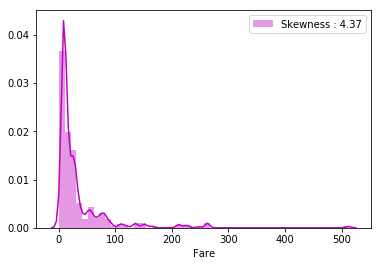

In [12]:
# 将连续数值分成bins
# 处理Fare
# 显示Fare的分布 
g = sns.distplot(data_all["Fare"], color="m", label="Skewness : %.2f"%(data_all["Fare"].skew()))
g = g.legend(loc="best")

从上面可以看出Fare的分布比较不均匀，对其通过log尺度变换进行处理。

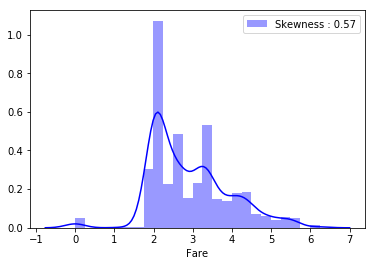

In [13]:
# Apply log to Fare to reduce skewness distribution
data_all["Fare"] = data_all["Fare"].map(lambda i: np.log(i) if i > 0 else 0)
g = sns.distplot(data_all["Fare"], color="b", label="Skewness : %.2f"%(data_all["Fare"].skew()))
g = g.legend(loc="best")

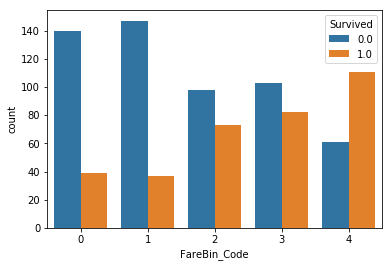

In [14]:
# 现在对Fare分成bins
# 这里选择qcut方法，对频率进行等距分箱
n_bins=5
data_all['FareBin'] = pd.qcut(data_all['Fare'], n_bins)
label = LabelEncoder()
data_all['FareBin_Code'] = label.fit_transform(data_all['FareBin'])

g = sns.countplot(x="FareBin_Code",hue='Survived',data=data_all.iloc[:train_len,:]) 

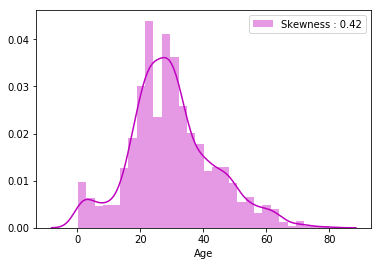

In [15]:
# 同样对年龄进行处理
g = sns.distplot(data_all["Age"], color="m", label="Skewness : %.2f"%(data_all["Age"].skew()))
g = g.legend(loc="best")

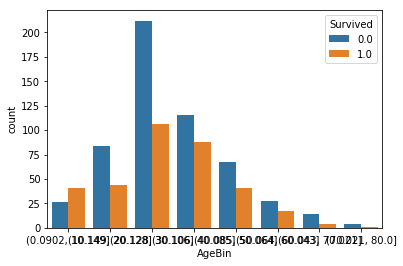

In [16]:
# 年龄的分布就比较均匀，不需要做任何预处理
# 这里用cut方法，对年龄选择等距分箱，分成n_bins_age个年龄段
n_bins_age=8
data_all['AgeBin'] = pd.cut(data_all['Age'], n_bins_age)
label = LabelEncoder()
data_all['AgeBin_Code'] = label.fit_transform(data_all['AgeBin'])

g = sns.countplot(x="AgeBin",hue='Survived',data=data_all.iloc[:train_len,:]) 

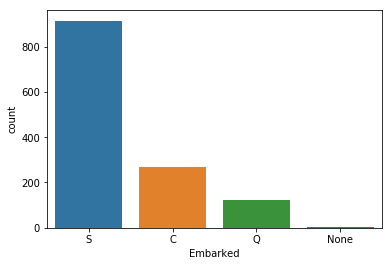

In [17]:
# 处理Embarked属性
g = sns.countplot(x="Embarked",data=data_all) 


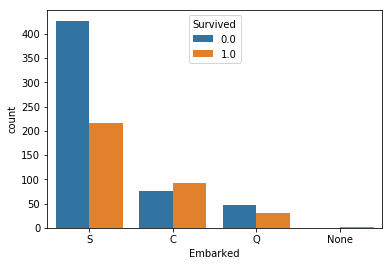

In [18]:
g = sns.countplot(x="Embarked",hue='Survived',data=data_all.iloc[:train_len,:]) 

对Embarked属性进行dummy操作

In [19]:
data_all=pd.get_dummies(data_all,columns=['Embarked'],prefix='Embarked')

剩下Ticket属性看起来比较复杂，先不做任何提取。

下面再继续看目前的data_all的信息。

In [20]:
data_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 23 columns):
Age                1309 non-null float64
Cabin              295 non-null object
Fare               1309 non-null float64
Name               1309 non-null object
Parch              1309 non-null int64
PassengerId        1309 non-null int64
Pclass             1309 non-null int64
Sex                1309 non-null int64
SibSp              1309 non-null int64
Survived           891 non-null float64
Ticket             1309 non-null object
Title              1309 non-null int64
Family_size        1309 non-null int64
Last_Name          1309 non-null object
Family_Survival    1309 non-null float64
FareBin            1309 non-null category
FareBin_Code       1309 non-null int64
AgeBin             1309 non-null category
AgeBin_Code        1309 non-null int64
Embarked_C         1309 non-null uint8
Embarked_None      1309 non-null uint8
Embarked_Q         1309 non-null uint8
Embarked_S         

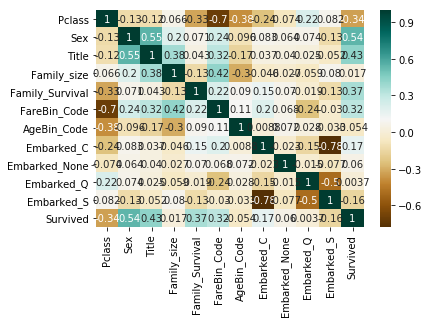

In [21]:
# 选用部分特征做为最终特征
data_all=data_all[['PassengerId','Pclass','Sex','Title','Family_size','Family_Survival','FareBin_Code','AgeBin_Code',
                  'Embarked_C','Embarked_None','Embarked_Q','Embarked_S','Survived']]

g = sns.heatmap(data_all.iloc[:train_len,:].drop(['PassengerId'],axis=1).corr(),cmap="BrBG",annot=True)

# Scale以及模型选择

In [22]:
X_train_original=data_all.iloc[:train_len,:].drop(['PassengerId','Survived'],axis=1)
Y_train=data_all.iloc[:train_len,:]['Survived'].astype(int)
test_original=data_all.iloc[train_len:,:].drop(['PassengerId','Survived'],axis=1)
IDtest=data_all.iloc[train_len:,:]['PassengerId']

In [23]:
# scalar
scaler=MinMaxScaler()
X_train= scaler.fit_transform(X_train_original)
test= scaler.transform(test_original)


In [24]:
# nn using skorch 
import torch
from torch import nn
import torch.nn.functional as F
torch.manual_seed(0)

In [25]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            num_units=20,
            nonlin=F.relu,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.num_units = num_units
        self.nonlin = nonlin
        self.dropout = dropout

        self.dense0 = nn.Linear(11, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(dropout)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X

In [26]:
from skorch import NeuralNetClassifier
from skorch.dataset import CVSplit
net = NeuralNetClassifier(
    ClassifierModule,
    max_epochs=500,
    lr=0.02,
    train_split=CVSplit(5),
#     device='cuda',  # uncomment this to train with CUDA
)
from sklearn.model_selection import GridSearchCV

X=X_train.astype(np.float32)
Y=Y_train.astype(np.int64)

params = {
    'lr': [0.02],
    'max_epochs': [500],
    'module__num_units': [20],
}
gs = GridSearchCV(net, params, refit=True,cv=2, scoring='accuracy')
gs.fit(X, Y)
print(gs.best_score_, gs.best_params_)
gs.estimator.set_params(**gs.best_params_).fit(X,Y)
IDtest=pd.read_csv('data/test.csv')['PassengerId']
test_Survived_nn=pd.Series(gs.predict(test.astype(np.float32)),name='Survived')
nn_results=pd.concat([IDtest,test_Survived_nn],axis=1)
nn_results.to_csv('nn_results.csv',index=False)
nn_results.head()

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7113       0.3596        0.7147  0.0156
      2        0.7090       0.3596        0.7087  0.0250
      3        0.7011       0.3596        0.7030  0.0210
      4        0.6964       0.3596        0.6980  0.0220
      5        0.6927       0.3933        0.6935  0.0260
      6        0.6895       0.6517        0.6895  0.0250
      7        0.6845       0.6629        0.6859  0.0230
      8        0.6832       0.6180        0.6823  0.0270
      9        0.6751       0.6629        0.6792  0.0250
     10        0.6734       0.6404        0.6763  0.0280
     11        0.6788       0.6180        0.6738  0.0240
     12        0.6710       0.6180        0.6714  0.0250
     13        0.6714       0.6404        0.6691  0.0250
     14        0.6688       0.6404        0.6670  0.0260
     15        0.6657       0.6404        0.6651  0.0270
     16        0.6678       0.6

    142        0.5517       0.7640        0.5311  0.0240
    143        0.5484       0.7753        0.5292  0.0240
    144        0.5475       0.7753        0.5277  0.0270
    145        0.5435       0.7865        0.5259  0.0250
    146        0.5479       0.7865        0.5244  0.0260
    147        0.5423       0.7978        0.5226  0.0220
    148        0.5392       0.7978        0.5209  0.0230
    149        0.5461       0.7978        0.5193  0.0230
    150        0.5487       0.7978        0.5178  0.0220
    151        0.5430       0.7865        0.5163  0.0220
    152        0.5487       0.7865        0.5149  0.0220
    153        0.5500       0.7865        0.5133  0.0200
    154        0.5234       0.7865        0.5115  0.0220
    155        0.5315       0.7865        0.5098  0.0260
    156        0.5476       0.7865        0.5084  0.0200
    157        0.5347       0.7865        0.5068  0.0220
    158        0.5271       0.7865        0.5050  0.0240
    159        0.5096       0.7

    285        0.4658       0.8202        0.4067  0.0220
    286        0.4245       0.8202        0.4056  0.0230
    287        0.4376       0.8202        0.4045  0.0230
    288        0.4644       0.8202        0.4044  0.0240
    289        0.4778       0.8202        0.4042  0.0260
    290        0.4562       0.8202        0.4036  0.0220
    291        0.4750       0.8202        0.4036  0.0220
    292        0.4760       0.8202        0.4035  0.0220
    293        0.4498       0.8202        0.4031  0.0250
    294        0.4331       0.8202        0.4026  0.0220
    295        0.4536       0.8202        0.4023  0.0250
    296        0.4332       0.8202        0.4018  0.0220
    297        0.4613       0.8202        0.4015  0.0230
    298        0.4576       0.8202        0.4010  0.0230
    299        0.4561       0.8202        0.4004  0.0230
    300        0.4435       0.8202        0.3999  0.0220
    301        0.4494       0.8202        0.3995  0.0210
    302        0.4734       0.8

    428        0.4510       0.8427        0.3808  0.0200
    429        0.4458       0.8427        0.3808  0.0200
    430        0.3941       0.8427        0.3802  0.0210
    431        0.4146       0.8427        0.3799  0.0220
    432        0.4341       0.8427        0.3796  0.0230
    433        0.4391       0.8427        0.3795  0.0230
    434        0.4250       0.8427        0.3793  0.0230
    435        0.4195       0.8427        0.3790  0.0210
    436        0.4276       0.8539        0.3791  0.0220
    437        0.4148       0.8539        0.3792  0.0230
    438        0.4223       0.8539        0.3791  0.0240
    439        0.4270       0.8539        0.3789  0.0210
    440        0.4009       0.8539        0.3782  0.0240
    441        0.4171       0.8539        0.3782  0.0240
    442        0.4344       0.8539        0.3783  0.0230
    443        0.4046       0.8539        0.3783  0.0230
    444        0.4212       0.8539        0.3780  0.0220
    445        0.4169       0.8

     69        0.6557       0.5667        0.6778  0.0220
     70        0.6564       0.5667        0.6776  0.0230
     71        0.6640       0.5667        0.6774  0.0220
     72        0.6642       0.5667        0.6771  0.0230
     73        0.6543       0.5667        0.6769  0.0220
     74        0.6637       0.5667        0.6767  0.0220
     75        0.6630       0.5667        0.6764  0.0220
     76        0.6609       0.5667        0.6762  0.0210
     77        0.6564       0.5667        0.6759  0.0200
     78        0.6638       0.5667        0.6757  0.0230
     79        0.6522       0.5667        0.6754  0.0220
     80        0.6578       0.5667        0.6752  0.0240
     81        0.6573       0.5667        0.6748  0.0240
     82        0.6589       0.5667        0.6746  0.0230
     83        0.6526       0.5667        0.6743  0.0210
     84        0.6520       0.5667        0.6740  0.0230
     85        0.6551       0.5667        0.6737  0.0240
     86        0.6519       0.5

    212        0.5591       0.7444        0.5511  0.0200
    213        0.5579       0.7444        0.5497  0.0210
    214        0.5618       0.7444        0.5482  0.0230
    215        0.5625       0.7444        0.5462  0.0220
    216        0.5777       0.7667        0.5446  0.0230
    217        0.5579       0.7667        0.5431  0.0240
    218        0.5734       0.7667        0.5416  0.0240
    219        0.5608       0.7778        0.5399  0.0230
    220        0.5624       0.8111        0.5385  0.0250
    221        0.5561       0.8222        0.5371  0.0220
    222        0.5479       0.8222        0.5357  0.0250
    223        0.5568       0.8222        0.5339  0.0260
    224        0.5563       0.8222        0.5323  0.0240
    225        0.5636       0.8222        0.5305  0.0230
    226        0.5468       0.8222        0.5292  0.0230
    227        0.5417       0.8222        0.5279  0.0240
    228        0.5490       0.8222        0.5261  0.0210
    229        0.5407       0.8

    355        0.4467       0.8667        0.4144  0.0230
    356        0.4447       0.8667        0.4137  0.0220
    357        0.4818       0.8667        0.4137  0.0250
    358        0.4707       0.8667        0.4136  0.0200
    359        0.4548       0.8667        0.4129  0.0240
    360        0.4720       0.8667        0.4124  0.0220
    361        0.4405       0.8667        0.4116  0.0250
    362        0.4653       0.8667        0.4112  0.0250
    363        0.4648       0.8667        0.4110  0.0230
    364        0.4816       0.8667        0.4108  0.0220
    365        0.4649       0.8667        0.4106  0.0230
    366        0.4559       0.8667        0.4102  0.0220
    367        0.4682       0.8667        0.4100  0.0240
    368        0.4624       0.8667        0.4096  0.0230
    369        0.4661       0.8667        0.4093  0.0230
    370        0.4569       0.8667        0.4089  0.0230
    371        0.4466       0.8667        0.4087  0.0220
    372        0.4576       0.8

    498        0.4022       0.8556        0.3809  0.0250
    499        0.4319       0.8556        0.3806  0.0240
    500        0.4225       0.8556        0.3803  0.0220
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6824       0.6704        0.6707  0.0490
      2        0.6774       0.6704        0.6666  0.0480
      3        0.6739       0.6704        0.6629  0.0440
      4        0.6717       0.6704        0.6594  0.0530
      5        0.6722       0.6704        0.6562  0.0460
      6        0.6675       0.6704        0.6534  0.0470
      7        0.6694       0.6704        0.6508  0.0460
      8        0.6678       0.6704        0.6484  0.0431
      9        0.6667       0.6704        0.6463  0.0520
     10        0.6636       0.6704        0.6443  0.0530
     11        0.6618       0.6704        0.6423  0.0500
     12        0.6611       0.6704        0.6405  0.0480
     13        0.6615       0.6

    139        0.4659       0.8156        0.4442  0.0470
    140        0.4781       0.8156        0.4433  0.0490
    141        0.4779       0.8156        0.4425  0.0490
    142        0.4722       0.8156        0.4412  0.0460
    143        0.4916       0.8156        0.4408  0.0470
    144        0.4626       0.8212        0.4395  0.0450
    145        0.4804       0.8156        0.4396  0.0480
    146        0.4661       0.8156        0.4389  0.0480
    147        0.4906       0.8156        0.4388  0.0500
    148        0.4530       0.8156        0.4380  0.0480
    149        0.4801       0.8156        0.4375  0.0490
    150        0.4668       0.8212        0.4369  0.0490
    151        0.4756       0.8212        0.4356  0.0490
    152        0.4490       0.8212        0.4344  0.0480
    153        0.4675       0.8212        0.4326  0.0530
    154        0.4856       0.8156        0.4321  0.0520
    155        0.4858       0.8212        0.4325  0.0450
    156        0.4756       0.8

    282        0.4313       0.8436        0.4000  0.0460
    283        0.4309       0.8492        0.3996  0.0450
    284        0.4376       0.8492        0.3996  0.0490
    285        0.4275       0.8436        0.3991  0.0430
    286        0.4397       0.8492        0.3988  0.0460
    287        0.4359       0.8492        0.3995  0.0410
    288        0.4457       0.8492        0.4001  0.0504
    289        0.4129       0.8492        0.3996  0.0460
    290        0.4401       0.8492        0.4001  0.0396
    291        0.4277       0.8492        0.3994  0.0440
    292        0.4293       0.8492        0.3999  0.0470
    293        0.4305       0.8436        0.3996  0.0450
    294        0.4581       0.8436        0.3997  0.0460
    295        0.4255       0.8436        0.3989  0.0420
    296        0.4377       0.8380        0.3996  0.0450
    297        0.4357       0.8380        0.4004  0.0460
    298        0.4356       0.8380        0.3996  0.0460
    299        0.4315       0.8

    425        0.4027       0.8436        0.3906  0.0420
    426        0.4064       0.8436        0.3914  0.0440
    427        0.4144       0.8436        0.3921  0.0473
    428        0.4087       0.8436        0.3917  0.0440
    429        0.4135       0.8436        0.3914  0.0450
    430        0.4102       0.8436        0.3917  0.0436
    431        0.4191       0.8436        0.3909  0.0440
    432        0.4140       0.8436        0.3915  0.0440
    433        0.4046       0.8436        0.3909  0.0470
    434        0.4172       0.8436        0.3913  0.0460
    435        0.4166       0.8436        0.3919  0.0461
    436        0.4299       0.8436        0.3913  0.0440
    437        0.4160       0.8436        0.3908  0.0460
    438        0.4130       0.8436        0.3913  0.0450
    439        0.4276       0.8436        0.3910  0.0410
    440        0.4205       0.8436        0.3912  0.0390
    441        0.4239       0.8436        0.3915  0.0490
    442        0.4080       0.8

     65        0.5445       0.7374        0.5362  0.0480
     66        0.5589       0.7430        0.5343  0.0460
     67        0.5388       0.7430        0.5321  0.0440
     68        0.5393       0.7542        0.5303  0.0460
     69        0.5432       0.7486        0.5282  0.0400
     70        0.5486       0.7542        0.5267  0.0460
     71        0.5415       0.7709        0.5250  0.0470
     72        0.5254       0.7709        0.5226  0.0460
     73        0.5368       0.7709        0.5204  0.0470
     74        0.5301       0.7654        0.5189  0.0460
     75        0.5232       0.7709        0.5167  0.0460
     76        0.5241       0.7654        0.5149  0.0470
     77        0.5327       0.7654        0.5133  0.0450
     78        0.5213       0.7654        0.5118  0.0472
     79        0.5198       0.7654        0.5100  0.0490
     80        0.5053       0.7654        0.5082  0.0470
     81        0.5081       0.7765        0.5069  0.0460
     82        0.5127       0.7

    208        0.4627       0.8045        0.4196  0.0440
    209        0.4537       0.8101        0.4189  0.0437
    210        0.4380       0.8101        0.4182  0.0470
    211        0.4351       0.8101        0.4179  0.0493
    212        0.4371       0.8101        0.4179  0.0460
    213        0.4235       0.8101        0.4177  0.0420
    214        0.4474       0.8045        0.4183  0.0450
    215        0.4491       0.8101        0.4180  0.0460
    216        0.4208       0.8101        0.4176  0.0416
    217        0.4360       0.8101        0.4174  0.0410
    218        0.4361       0.8101        0.4176  0.0548
    219        0.4310       0.8101        0.4169  0.0390
    220        0.4381       0.8101        0.4169  0.0480
    221        0.4396       0.8101        0.4169  0.0470
    222        0.4530       0.8101        0.4175  0.0470
    223        0.4307       0.8156        0.4169  0.0450
    224        0.4381       0.8101        0.4167  0.0450
    225        0.4484       0.8

    351        0.4235       0.8436        0.3978  0.0470
    352        0.4263       0.8380        0.3976  0.0420
    353        0.4119       0.8380        0.3975  0.0460
    354        0.4214       0.8380        0.3972  0.0483
    355        0.4202       0.8436        0.3974  0.0460
    356        0.4229       0.8380        0.3971  0.0440
    357        0.4072       0.8380        0.3970  0.0453
    358        0.4112       0.8380        0.3968  0.0420
    359        0.4108       0.8380        0.3967  0.0450
    360        0.4118       0.8380        0.3964  0.0450
    361        0.4199       0.8380        0.3961  0.0480
    362        0.4198       0.8380        0.3964  0.0460
    363        0.4180       0.8436        0.3964  0.0450
    364        0.4065       0.8436        0.3961  0.0460
    365        0.4290       0.8436        0.3965  0.0480
    366        0.4172       0.8436        0.3962  0.0450
    367        0.4182       0.8436        0.3965  0.0450
    368        0.4071       0.8

    494        0.4024       0.8436        0.3941  0.0430
    495        0.4077       0.8436        0.3939  0.0450
    496        0.3961       0.8436        0.3936  0.0470
    497        0.3984       0.8436        0.3936  0.0430
    498        0.4080       0.8436        0.3935  0.0440
    499        0.3977       0.8436        0.3936  0.0450
    500        0.4043       0.8436        0.3934  0.0470


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
D:\Anaconda\lib\site-packages\sklearn\di

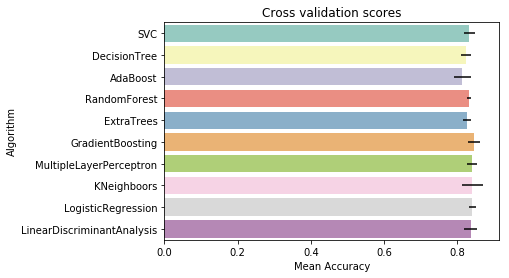

In [27]:
kfold = StratifiedKFold(n_splits=5)

# Modeling step Test differents algorithms
random_state = 2
classifiers = []


classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state,
                                          learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame(
        {"CrossValMeans": cv_means, "CrossValerrors": cv_std, "Algorithm": ["SVC", "DecisionTree", "AdaBoost",
                                                                            "RandomForest", "ExtraTrees",
                                                                            "GradientBoosting",
                                                                            "MultipleLayerPerceptron", "KNeighboors",
                                                                            "LogisticRegression",
                                                                            "LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr': cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [28]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion": ["entropy"],
                      "base_estimator__splitter": [ "random"],
                      "algorithm": ["SAMME"],
                      "n_estimators": [100],
                      "learning_rate": [0.0001]}

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsadaDTC.fit(X_train, Y_train)

ada_best = gsadaDTC.best_estimator_
print('AdaBoost:')
print(gsadaDTC.best_params_)
print(gsadaDTC.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


AdaBoost:
{'algorithm': 'SAMME', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'random', 'learning_rate': 0.0001, 'n_estimators': 100}
0.8294051627384961


In [29]:
# ExtraTrees
ExtC = ExtraTreesClassifier()

## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
                     "max_features": [0.2,0.3],
                     "min_samples_split": [3,5],
                     "min_samples_leaf": [5,],
                     "bootstrap": [False],
                     "n_estimators": [500],
                     "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)

gsExtC.fit(X_train, Y_train)

print('Extra Tree:')
ExtC_best = gsExtC.best_estimator_
print(gsExtC.best_params_)
# Best score
print(gsExtC.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    8.0s finished


Extra Tree:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 500}
0.8462401795735129


In [30]:
#xgboost
XGBC = xgboost.sklearn.XGBClassifier()
xgbc_param_grid = {
                     "n_estimators": [500],
                    'learning_rate':[0.001],
                    'max_depth':[3],
                    'booster':['gbtree']}

gsXGBC= GridSearchCV(XGBC, param_grid=xgbc_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsXGBC.fit(X_train, Y_train)
print('xgboost:')
XGBC_best = gsXGBC.best_estimator_
print(gsXGBC.best_params_)
print(gsXGBC.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.6s finished


xgboost:
{'booster': 'gbtree', 'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 500}
0.8518518518518519


In [31]:
LR=LogisticRegression()
lr_param_grid = {
       'penalty':['l1'],
        'tol':[1e-4],
        'C':[10]}
gsLR = GridSearchCV(LR, param_grid=lr_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsLR.fit(X_train, Y_train)
print('Logistic Regression:')
LR_best = gsLR.best_estimator_
print(gsLR.best_params_)
print(gsLR.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.5s finished


Logistic Regression:
{'C': 10, 'penalty': 'l1', 'tol': 0.0001}
0.8361391694725028


In [32]:
# RFC Parameters tunning
RFC = RandomForestClassifier()

## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
                "max_features": ['auto',0.3],
                "min_samples_split": [5],
                "min_samples_leaf": [6],
                "bootstrap": [False],
                "n_estimators": [150],
                "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
print('Random Forest:')
RFC_best = gsRFC.best_estimator_
print(gsRFC.best_params_)
# Best score
print(gsRFC.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    3.8s finished


Random Forest:
{'bootstrap': False, 'criterion': 'gini', 'max_depth': None, 'max_features': 0.3, 'min_samples_leaf': 6, 'min_samples_split': 5, 'n_estimators': 150}
0.8529741863075196


In [33]:
# Gradient boosting tunning
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ["deviance"],
                     'n_estimators': [200],
                     'learning_rate': [0.01],
                     'max_depth': [4],
                     'min_samples_leaf': [100],
                     "max_features": ['auto']
                     }

gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsGBC.fit(X_train, Y_train)
print('Gradient Boost:')
print(gsGBC.best_params_)
GBC_best = gsGBC.best_estimator_
print(gsGBC.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


Gradient Boost:
{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 100, 'n_estimators': 200}
0.8484848484848485


In [34]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                      'gamma': [ 1],
                      'C': [0.1]}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring="accuracy", n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)
print('SVC')
print(gsSVMC.best_params_)
SVMC_best = gsSVMC.best_estimator_
# Best score
print(gsSVMC.best_score_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    2.7s finished


SVC
{'C': 0.1, 'gamma': 1, 'kernel': 'rbf'}
0.8305274971941639


In [35]:
#Voting
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
                                           ('svc', SVMC_best), ('adac', ada_best), ('gbc', GBC_best),
                                           ('xgbc',XGBC_best),('lr',LR_best)], voting='soft',
                               n_jobs=4)

votingC = votingC.fit(X_train, Y_train)
voting_score=cross_val_score(votingC, X_train, y=Y_train, scoring="accuracy", cv=kfold)
print('voting:',voting_score)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

voting: [0.86592179 0.84357542 0.85393258 0.81460674 0.84745763]


In [36]:
stack = StackingClassifier(classifiers=[RFC_best, ExtC_best,SVMC_best,ada_best,GBC_best,LR_best],
                              meta_classifier=XGBC_best)
stack = stack.fit(X_train, Y_train)
stack_score=cross_val_score(stack,X_train, y=Y_train, scoring="accuracy", cv=kfold)
print('stack_score:',stack_score)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.si

stack_score: [0.83240223 0.81564246 0.85393258 0.82022472 0.82485876]


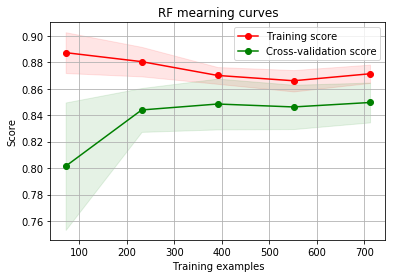

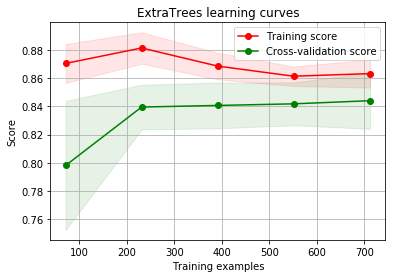

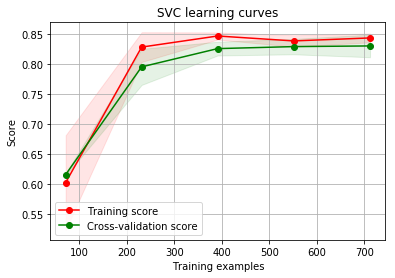

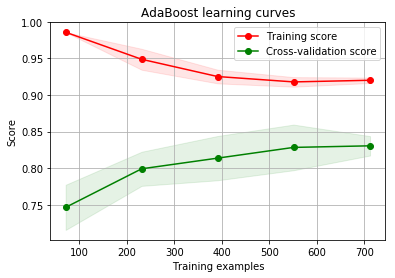

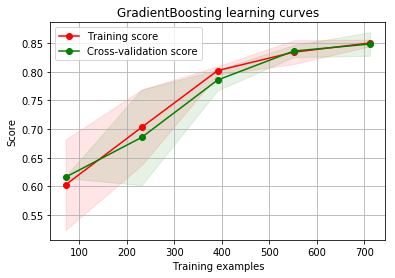

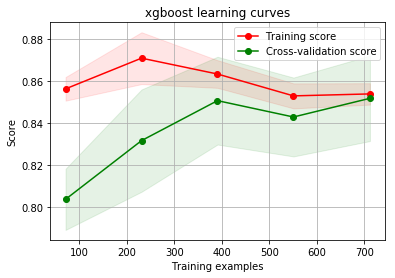

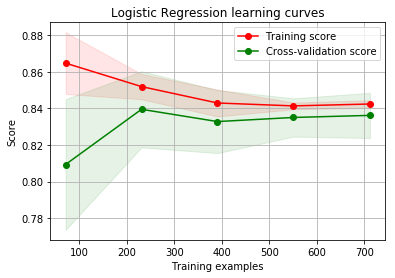

In [37]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
        """Generate a simple plot of the test and training learning curve"""
        plt.figure()
        plt.title(title)
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        train_sizes, train_scores, test_scores = learning_curve(
            estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
        plt.legend(loc="best")
        return plt

g = plot_learning_curve(gsRFC.best_estimator_, "RF mearning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtraTrees learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVC learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "AdaBoost learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GradientBoosting learning curves", X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsXGBC.best_estimator_,"xgboost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsLR.best_estimator_,"Logistic Regression learning curves",X_train,Y_train,cv=kfold)

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


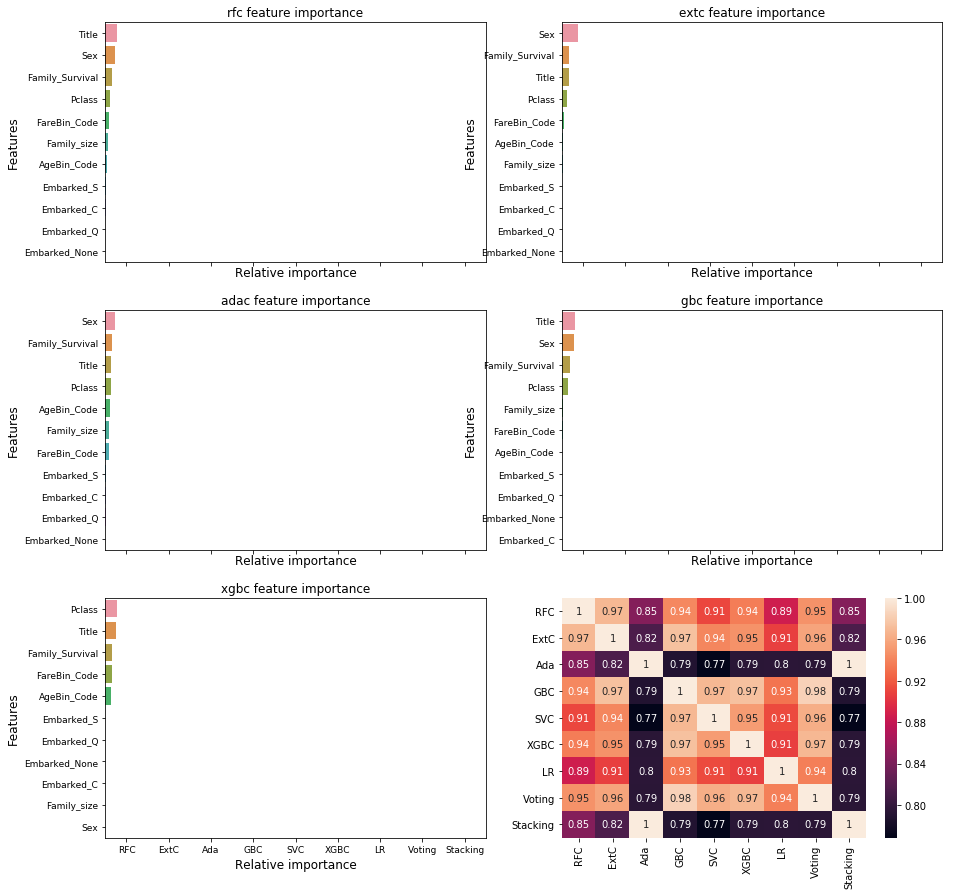

In [38]:
nrows =3
ncols=2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex="all", figsize=(15, 15))
names_classifiers = [('rfc', RFC_best), ('extc', ExtC_best),
                        ('adac', ada_best), ('gbc', GBC_best),
                        ('xgbc',XGBC_best)]
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        if nclassifier>=5:
            break
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train_original.columns[indices][:40], x=classifier.feature_importances_[indices][:40],
                            orient='h', ax=axes[row][col])
        g.set_xlabel("Relative importance", fontsize=12)
        g.set_ylabel("Features", fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1


test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_XGBC=pd.Series(XGBC_best.predict(test),name='XGBC')
test_Survived_LR=pd.Series(LR_best.predict(test),name='LR')
test_Survived_Voting=pd.Series(votingC.predict(test),name='Voting')
test_Survived_Stacking=pd.Series(stack.predict(test),name='Stacking')
    # Concatenate all classifier results
ensemble_results = pd.concat(
        [test_Survived_RFC, test_Survived_ExtC, test_Survived_AdaC, test_Survived_GBC, test_Survived_SVMC,
         test_Survived_XGBC,test_Survived_LR,test_Survived_Voting,test_Survived_Stacking], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

In [39]:
IDtest=pd.read_csv('data/test.csv')['PassengerId']
test_Survived = pd.Series(votingC.predict(test), name="Survived")
test_Survived_XGBC_submition=pd.Series(XGBC_best.predict(test),name='Survived')
xgbc_results=pd.concat([IDtest,test_Survived_XGBC_submition],axis=1)
xgbc_results.to_csv('xgbc.csv',index=False)
print(IDtest.shape)
print(test_Survived.shape)
results = pd.concat([IDtest, test_Survived], axis=1)
results.to_csv("ensemble_python_voting.csv", index=False)

test_Survived_Stacking=pd.Series(stack.predict(test),name='Survived')
stacking_results=pd.concat([IDtest,test_Survived_Stacking],axis=1)
stacking_results.to_csv('stacking.csv',index=False)
results.head()

D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


(418,)
(418,)


D:\Anaconda\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
